In [1]:
from mesmerize_core import *
import tifffile
import numpy as np
from matplotlib import pyplot as plt

/home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/pandas/compat/_optional.py:149: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)
2022-06-03 00:19:00.522921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-03 00:19:00.522959: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# set the parent directory as the top-level directory for your experiment data
set_parent_data_path("/home/kushal/ccn-2020-workshop/")

batch_path = "/home/kushal/ccn-2020-workshop/mesmerize-demos/mesmerize-core-batch/batch-demo.pickle"

# create a new batch
df = create_batch(batch_path)
df

,algo,name,input_movie_path,params,outputs,uuid


In [3]:
# path to raw movie tiff file
movie_path = "/home/kushal/ccn-2020-workshop/mesmerize-demos/movies/sue_movie.tif"

# params, exactly the same as what you'd directly use with CaImAn
mcorr_params1 =\
{
  'mcorr_kwargs': # this key is necessary for specifying that these are mcorr kwargs
    {
        'max_shifts': [24, 24],
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

In [4]:
# add an item to the batch
df.caiman.add_item(
  algo='mcorr',
  name='my_movie',
  input_movie_path=movie_path,
  params=mcorr_params1
)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",None,dea6166d-1a66-4136-a17e-4a7dc2481289


In [5]:
# We create another set of params, useful for gridsearches for example
mcorr_params2 =\
{
  'mcorr_kwargs': # this key is necessary for specifying that these are mcorr kwargs
    {
        'max_shifts': [24, 24],
        'strides': [24, 24],
        'overlaps': [12, 12],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# add other param variant to the batch
df.caiman.add_item(
  algo='mcorr',
  name='my_movie',
  input_movie_path=movie_path,
  params=mcorr_params2
)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",None,dea6166d-1a66-4136-a17e-4a7dc2481289
1,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",None,0c30cbb8-d87b-4d94-9e94-3755c6dcb8b3


In [6]:
# run the first "batch item"
process = df.iloc[0].caiman.run(
  batch_path=batch_path,
  backend=COMPUTE_BACKEND_SUBPROCESS,  # this is for non-GUI use, COMPUTE_BACKEND_QPROCESS is for use within a Qt GUI
  callbacks_finished=[lambda: print("yay finished")], # callback function for when this item finishes
)
process.wait()

/home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/pandas/compat/_optional.py:149: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)
2022-06-03 00:19:18.677595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:/home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-03 00:19:18.677620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


starting mc


100%|██████████| 1/1 [00:00<00:00,  6.91it/s]



mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
{'mean-projection-path': PosixPath('mesmerize-demos/movies/dea6166d-1a66-4136-a17e-4a7dc2481289_mean_projection.npy'), 'std-projection-path': PosixPath('mesmerize-demos/movies/dea6166d-1a66-4136-a17e-4a7dc2481289_std_projection.npy'), 'max-projection-path': PosixPath('mesmerize-demos/movies/dea6166d-1a66-4136-a17e-4a7dc2481289_max_projection.npy'), 'mcorr-output-path': PosixPath('mesmerize-demos/movies/dea6166d-1a66-4136-a17e-4a7dc2481289-sue_movie_els__d1_170_d2_170_d3_1_order_F_frames_3000_.mmap'), 'corr-img-path': PosixPath('mesmerize-demos/movies/dea6166d-1a66-4136-a17e-4a7dc2481289_cn.npy'), 'shifts': PosixPath('mesmerize-demos/movies/dea6166d-1a66-4136-a17e-4a7dc2481289_shifts.npy'), 'success': True, 'traceback': None}


0

In [7]:
df = load_batch(batch_path)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",{'mean-projection-path': mesmerize-demos/movie...,dea6166d-1a66-4136-a17e-4a7dc2481289
1,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",None,0c30cbb8-d87b-4d94-9e94-3755c6dcb8b3


In [8]:
input_movie = tifffile.imread(df.iloc[0].caiman.get_input_movie_path()).astype(np.float32)

# extension for loading the mcorr movie
# np.float32 because Nvidia doesn't support 64bit floats on desktop GPUs
mcorr_movie = df.iloc[0].mcorr.get_output().astype(np.float32)

In [9]:
from fastplotlib import GridPlot, Image, Plot
from ipywidgets.widgets import IntSlider

RFBOutputContext()

MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0




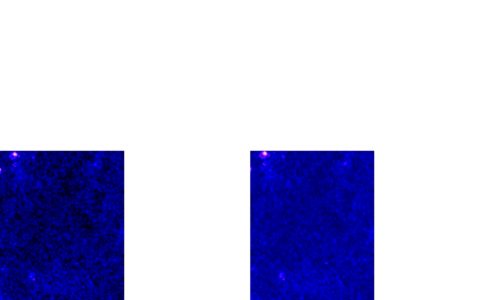

JupyterWgpuCanvas()

In [10]:
# gridplot with 1 row, 2 columns
gp = GridPlot(
    shape=(1, 2),
    controllers=np.array([[0, 0]]) # this is to that we can pan-zoom in sync :D 
)

input_graphic = Image(
    data=input_movie[0], # image data for the first frame
    cmap='gnuplot2' # my favorite colormap
)

mcorr_graphic = Image(
    data=mcorr_movie[0], # image data for the first frame
    cmap='gnuplot2'
)

# add the grahpics to the subplots
gp.subplots[0, 0].add_graphic(input_graphic)
gp.subplots[0, 1].add_graphic(mcorr_graphic)

# make a GUI slider
slider = IntSlider(value=0, min=0, max=input_movie.shape[0] - 1, step=1)

previous_value = 0

# a function to update the frame based on the slider value
def update_frame():
    global previous_value
    if previous_value == slider.value:
        return
    
    input_graphic.update_data(input_movie[slider.value])
    mcorr_graphic.update_data(mcorr_movie[slider.value])
    
# add to the animation so that this is run in every render cycle
gp.add_animations([update_frame])
gp.show()

In [11]:
slider

IntSlider(value=0, max=2999)

In [12]:
# We can continue from mcorr above and perform CNMF using the mcorr output

# some params for CNMF
params_cnmf =\
{
    'cnmf_kwargs':
        {
            'p': 1,
            'nb': 1,
            # raises error: no parameter 'merge_thresh' found
            # 'merge_thresh': 0.7,
            'rf': None,
            'stride': 30,
            'K': 10,
            'gSig': [3, 3],
            'ssub': 1,
            'tsub': 1,
            'method_init': 'greedy_roi',
        },
    'eval_kwargs':
        {
            'min_SNR': 1.5,
            'rval_thr': 0.7,
            'use_cnn': True,
            'min_cnn_thr': 0.8,
            'cnn_lowest': 0.1,
            'decay_time': 1,
        },
    'refit': True,
}

df.caiman.add_item(
  algo='cnmf',
  name='my_movie',
  input_movie_path=df.iloc[0].mcorr.get_output_path(),  # use mcorr output from a previous item
  params=params_cnmf
)

# run this item
process = df.iloc[-1].caiman.run(
  batch_path=batch_path,
  backend=COMPUTE_BACKEND_SUBPROCESS,
  callbacks_finished=[lambda: print("yay finished")],
)

/home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/pandas/compat/_optional.py:149: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)
2022-06-03 00:21:18.533023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:/home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-03 00:21:18.533053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


cnmf params {'cnmf_kwargs': {'p': 1, 'nb': 1, 'rf': None, 'stride': 30, 'K': 10, 'gSig': [3, 3], 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi'}, 'eval_kwargs': {'min_SNR': 1.5, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 1}, 'refit': True}
making memmap


2022-06-03 00:21:47.828186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:/home/kushal/python-venvs/mesmerize-napari/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-03 00:21:47.828295: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 00:21:47.828357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kushal-debian-thinkpad): /proc/driver/nvidia/version does not exist
2022-06-03 00:21:47.830474: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
1/1 [==============================] - 0s 276ms/step
Final output dict:
{'mean-projection-path': PosixPath('mesmerize-demos/movies/3321043a-6f73-4a6d-b02f-98a4fb0a7be5_mean_projection.npy'), 'std-projection-path': PosixPath('mesmerize-demos/movies/3321043a-6f73-4a6d-b02f-98a4fb0a7be5_std_projection.npy'), 'max-projection-path': PosixPath('mesmerize-demos/movies/3321043a-6f73-4a6d-b02f-98a4fb0a7be5_max_projection.npy'), 'cnmf-hdf5-path': PosixPath('mesmerize-demos/movies/3321043a-6f73-4a6d-b02f-98a4fb0a7be5.hdf5'), 'cnmf-memmap-path': PosixPath('mesmerize-demos/movies/3321043a-6f73-4a6d-b02f-98a4fb0a7be5_cnmf-memmap__d1_170_d2_170_d3_1_order_C_frames_3000_.mmap'), 'corr-img-path': PosixPath('mesmerize-demos/movies/3321043a-6f73-4a6d-b02f-98a4fb0a7be5_cn.npy'), 'success': True, 'traceback': None}


In [14]:
df = load_batch(batch_path)
df

,algo,name,input_movie_path,params,outputs,uuid
0,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",{'mean-projection-path': mesmerize-demos/movie...,dea6166d-1a66-4136-a17e-4a7dc2481289
1,mcorr,my_movie,mesmerize-demos/movies/sue_movie.tif,"{'mcorr_kwargs': {'max_shifts': [24, 24], 'str...",None,0c30cbb8-d87b-4d94-9e94-3755c6dcb8b3
2,cnmf,my_movie,mesmerize-demos/movies/dea6166d-1a66-4136-a17e...,"{'cnmf_kwargs': {'p': 1, 'nb': 1, 'rf': None, ...",{'mean-projection-path': mesmerize-demos/movie...,3321043a-6f73-4a6d-b02f-98a4fb0a7be5


In [15]:
df.iloc[-1]

algo                                                             cnmf
name                                                         my_movie
input_movie_path    mesmerize-demos/movies/dea6166d-1a66-4136-a17e...
params              {'cnmf_kwargs': {'p': 1, 'nb': 1, 'rf': None, ...
outputs             {'mean-projection-path': mesmerize-demos/movie...
uuid                             3321043a-6f73-4a6d-b02f-98a4fb0a7be5
Name: 2, dtype: object

In [16]:
# get the motion corrected movie as a memmap
cnmf_movie = df.iloc[-1].cnmf.get_input_memmap()

# we can get the contours of the spatial components
coors, coms = df.iloc[-1].cnmf.get_spatial_contours()

RFBOutputContext()


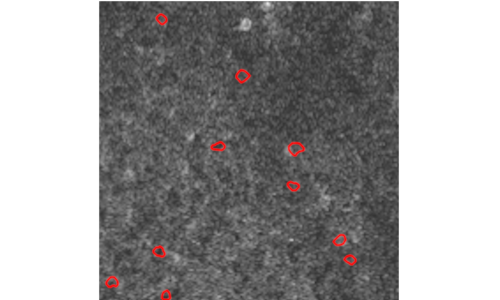

JupyterWgpuCanvas()

In [22]:
# create a simple plot
plot = Plot()

# plot the first frame
image_graphic = plot.image(data=cnmf_movie[0], cmap='gray')

# plot all the contours
for coor in coors:
    # line data has to be 3D
    zs = np.ones(coor.shape[0]) # this will place it above the image
    coors_3d = np.dstack([coor[:, 0], coor[:, 1], zs])[0].astype(np.float32)
    
    # red color, just [R, G, B, A] -> red, green, blue, alpha (transparency)
    colors = np.vstack([[1., 0., 0., 1.]] * coors_3d.shape[0]).astype(np.float32)
    plot.line(data=coors_3d, colors=colors)

# make a slider like for mcorr
slider_cnmf = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1)
    
previous_ix = 0

# animate func just like mcorr viz
def update_frame():
    if slider_cnmf.value == previous_ix:
        return
    image_graphic.update_data(data=cnmf_movie[slider_cnmf.value])

plot.add_animations([update_frame])
    
plot.show()

In [23]:
slider_cnmf

IntSlider(value=0, max=2999)